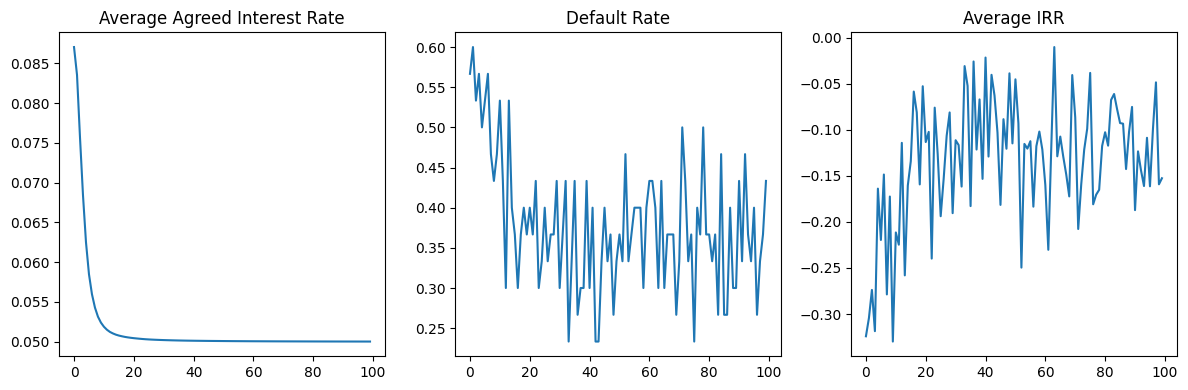

In [52]:
import numpy as np
import numpy_financial as npf
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

# Define the borrower agent
class Borrower:
    def __init__(self, attributes, default_risk, max_rate):
        self.attributes = attributes
        self.ideal_rate = np.random.uniform(0.0, max_rate) # hidden attribute
        self.default_risk = default_risk  # Hidden attribute
        self.max_rate = max_rate  # Maximum acceptable interest rate

    def choose_lender(self, offers):
        # Accept the lowest offer within acceptable rates
        acceptable_offers = [offer for offer in offers if offer <= self.max_rate]
        if acceptable_offers:
            chosen = min(acceptable_offers)
            # update default risk based on chosen rate
            self.default_risk = self.default_risk + min(0, chosen - self.ideal_rate)
            return chosen
        else:
            # If no acceptable offers, accept the lowest available
            chosen = min(offers)
            self.default_risk = self.default_risk + min(0, chosen - self.ideal_rate)
            return chosen

# Define the lender agent with a neural network policy
class Lender(nn.Module):
    def __init__(self, input_size):
        super(Lender, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.memory = deque(maxlen=1000)

    def forward(self, x):
        return self.fc(x)

    def act(self, borrower_attributes):
        with torch.no_grad():
            output = self.forward(torch.FloatTensor(borrower_attributes))
        # Scale output to interest rate range
        min_rate = 0.05
        max_rate = 0.15
        interest_rate = output.item() * (max_rate - min_rate) + min_rate
        return interest_rate

    def remember(self, state, reward):
        self.memory.append((state, reward))

    def learn(self):
        if len(self.memory) < 32:
            return
        batch = random.sample(self.memory, 32)
        states, rewards = zip(*batch)
        states = torch.FloatTensor(states)
        rewards = torch.FloatTensor(rewards)
        predictions = self.forward(states).squeeze()
        # Scale predictions back to rate range
        min_rate = 0.05
        max_rate = 0.15
        scaled_predictions = predictions * (max_rate - min_rate) + min_rate
        loss = nn.MSELoss()(scaled_predictions, rewards)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Simulation parameters
num_episodes = 100
num_borrowers = 30
num_lenders = 30
loan_amount = 1000  # Principal amount
loan_term = 6  # Months

# Initialize lenders and borrowers
lenders = [Lender(input_size=3) for _ in range(num_lenders)]  # Assuming 3 borrower attributes
borrowers = [Borrower(
    attributes=np.random.rand(3),
    default_risk=np.random.uniform(0.01, 0.3),  # Default risk between 1% and 30%
    max_rate=np.random.uniform(0.05, 0.15)
) for _ in range(num_borrowers)]

# Tracking metrics
avg_interest_rates = []
default_rates = []
avg_irrs = []

for episode in range(num_episodes):
    agreed_rates = []
    defaults = 0
    irrs = []
    num_loans = 0

    # Each borrower requests a loan
    for borrower in borrowers:
        offers = []
        for lender in lenders:
            rate_offer = lender.act(borrower.attributes)
            offers.append(rate_offer)
        agreed_rate = borrower.choose_lender(offers)
        agreed_rates.append(agreed_rate)
        num_loans += 1

        # Simulate loan performance over 6 months
        monthly_rate = agreed_rate / 12
        payment = npf.pmt(monthly_rate, loan_term, -loan_amount)
        cash_flows = [-loan_amount]
        default_occurred = False

        for month in range(1, loan_term + 1):
            # Determine if borrower defaults this month
            default_probability = borrower.default_risk * (1 + agreed_rate)
            if np.random.rand() < default_probability:
                # Borrower defaults
                defaults += 1
                default_occurred = True
                # No payment from this point onwards
                cash_flows += [0] * (loan_term - month + 1)
                break
            else:
                # Borrower makes payment
                cash_flows.append(payment)

        if not default_occurred:
            # Early payoff probability inversely related to rate
            early_payoff_probability = 0.1 / agreed_rate
            if np.random.rand() < early_payoff_probability:
                # Borrower pays off remaining balance
                remaining_balance = npf.fv(monthly_rate, loan_term - len(cash_flows) + 1, payment, -loan_amount)
                cash_flows[-1] += remaining_balance
                cash_flows += [0] * (loan_term - len(cash_flows) + 1)

        # Calculate IRR
        try:
            irr = npf.irr(cash_flows)
            # Bound IRR to realistic values
            if np.isnan(irr) or irr < -1:
                irr = -1.0
            elif irr > 0.15:  # Cap at 15% annual return
                irr = 0.15
        except:
            irr = -1.0  # Default to total loss if calculation fails
        irrs.append(irr)  # Store as decimal, not percentage

        # Lender learns from outcome
        lender_state = borrower.attributes
        reward = irr if not np.isnan(irr) else -1.0  # Handle cases where IRR cannot be calculated
        # Find which lender made the loan
        lender_index = offers.index(agreed_rate)
        lender = lenders[lender_index]
        lender.remember(lender_state, reward)
        lender.learn()

    # Record metrics
    avg_interest_rates.append(np.mean(agreed_rates))
    default_rates.append(defaults / num_loans)
    avg_irrs.append(np.mean(irrs))

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(avg_interest_rates)
plt.title('Average Agreed Interest Rate')

plt.subplot(1, 3, 2)
plt.plot(default_rates)
plt.title('Default Rate')

plt.subplot(1, 3, 3)
plt.plot(avg_irrs)
plt.title('Average IRR')

plt.tight_layout()
plt.show()